# NLP w/Disaster Tweets

### Each sample in the train and test set has the following information:

1) The text of a tweet

2) A keyword from that tweet

3) The location the tweet was sent from 

### Files: 

1) train.csv - the training set

2) test.csv - the test set

3) sample_submission.csv - a sample submission file in the correct format

### Columns:

1) id - a unique identifier for each tweet

2) text - the text of the tweet

3) location - the location the tweet was sent from (may be blank)

4) keyword - a particular keyword from the tweet (may be blank)

5) target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

### Purpose:

We are meant to predict whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [2]:
train=pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


## Visualizations/Exploratory Data Analysis: 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'count')

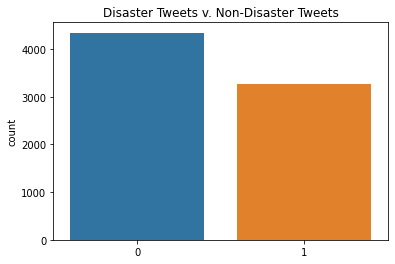

In [5]:
x=train.target.value_counts()
sns.barplot(x.index,x).set(title='Disaster Tweets v. Non-Disaster Tweets')
plt.gca().set_ylabel('count')

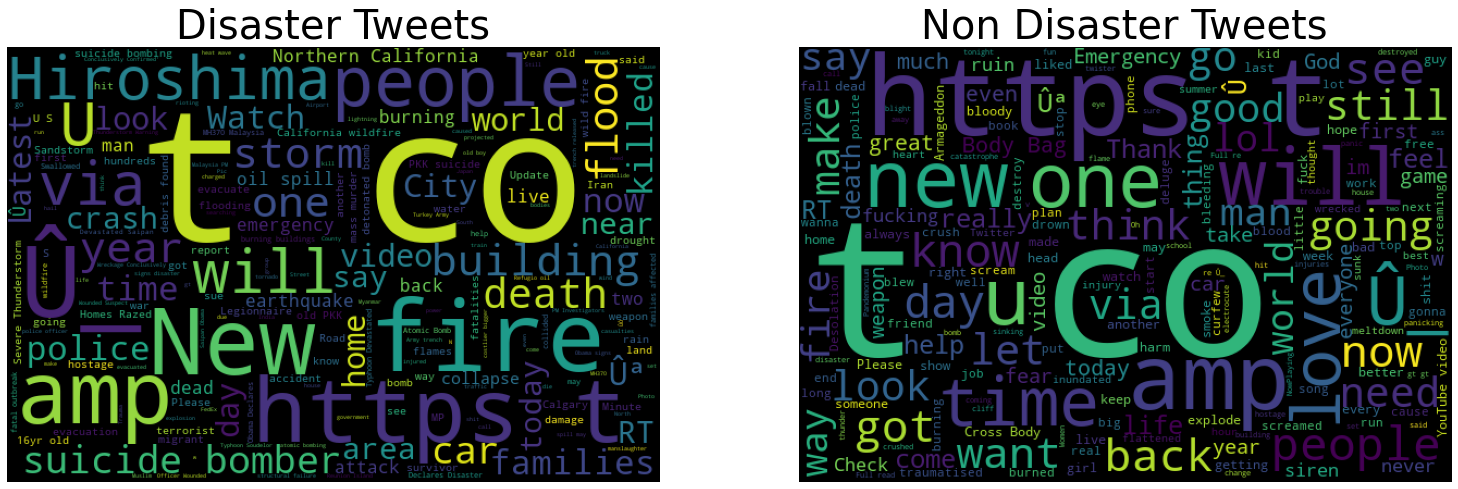

In [6]:
disaster= train[train['target']==1]['text']
non_disaster= train[train['target']==0]['text']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='black',
                        width=600,
                        height=400).generate(" ".join(disaster))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='black',
                        width=600,
                        height=400).generate(" ".join(non_disaster))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

In [7]:
kw_train=train['keyword'].value_counts()
kw_train

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

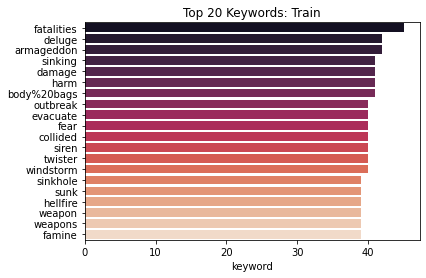

In [8]:
x=kw_train[:20]
sns.barplot(y=x.index, x=x, palette='rocket', data=train).set(title='Top 20 Keywords: Train')
sns.set(rc={'figure.figsize':(8,8)})

In [9]:
kw_test=test['keyword'].value_counts()
kw_test

deluged               23
demolished            22
rubble                22
first%20responders    21
seismic               21
                      ..
threat                 5
fatalities             5
forest%20fire          5
inundation             4
epicentre              1
Name: keyword, Length: 221, dtype: int64

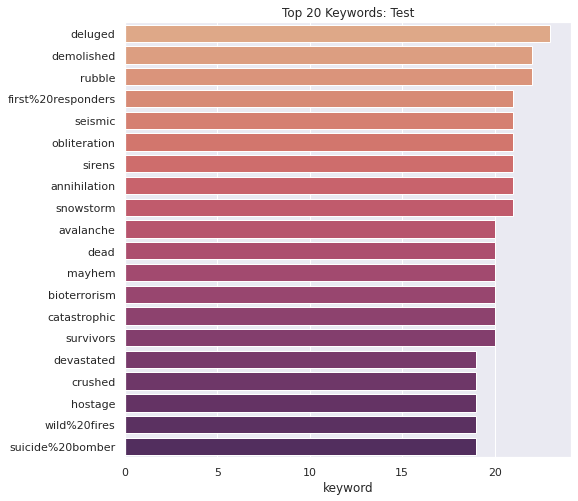

In [10]:
x=kw_test[:20]
sns.barplot(y=x.index, x=x, palette='flare', data=test).set(title='Top 20 Keywords: Test')
sns.set(rc={'figure.figsize':(8,8)})

## Data Cleaning: 

In [11]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Given that most of the null values are in the keyword and location columns in both the training and test datasets, I decided to drop both of these features:

In [13]:

tweets_train = train[["id", "text", "target"]].sort_values(by = "id")
tweets_test = test[["id", "text"]].sort_values(by = "id")


tweets_train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In the process of data cleaning in NLP, it is inportant to perform text preprocessing, in order to convert the data into a predictable and analyzable form. In this case, I have done that through three steps:

1) Stop Words

2) Lemmatization

3) Tokenization

For the first step, stop words are low-level words such as articles, prepositions, pronouns, conjunctions that dont add much information to the text, and can be removed in order to give more focus to the important information.  Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. I got the following function from the article below, which manages to perform both stop word removal and lemmatization: 

https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a

https://medium.com/swlh/text-classification-using-tf-idf-7404e75565b8

In [14]:
def erase_stopwords(ds: pd.Series) -> pd.Series: 
    """
    Apply NLP Preprocessing Techniques to the reviews.
    """
    for m in range(len(ds)):
        if m % 1000 == 0: 
            print(m)
        main_words = re.sub('[^a-zA-Z]', ' ', ds[m])                                      
        main_words = (main_words.lower()).split()
        main_words = [w for w in main_words if not w in set(stopwords.words('english'))]  
        
        lem = WordNetLemmatizer()
        main_words = [lem.lemmatize(w) for w in main_words if len(w) > 1]                
        
        main_words = ' '.join(main_words)
        ds[m] = main_words

    return ds

tweets_train["proper_text"] = erase_stopwords(tweets_train["text"])
tweets_test["proper_text"] = erase_stopwords(tweets_test["text"])

0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1000
2000
3000
4000
5000
6000
7000
0
1000
2000
3000


The next step I took in data cleaning is tokenization. This is the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.

Citation:

https://dev.to/balapriya/tokenization-and-sequencing-in-tensorflow-3p0n

In [15]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(tweets_train['proper_text'].values)
X = tokenizer.texts_to_sequences(tweets_train['proper_text'].values)
X = pad_sequences(X)
y = tweets_train['target']

## Split dataset into train-test/Constructing Model: 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =41)


The first model I decided to construct is an LSTM model. 

Citation:

https://medium.com/@dclengacher/keras-lstm-recurrent-neural-networks-c1f5febde03d

#### LSTM Model: 

In [17]:
model = Sequential()
model.add(Embedding(max_features, 32,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.001)

model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

history = model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))

2022-10-08 02:02:13.121699: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 32)            96000     
_________________________________________________________________
dropout (Dropout)            (None, 21, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


2022-10-08 02:02:13.788821: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


191/191 [==============================] - 7s 21ms/step - loss: 0.5836 - accuracy: 0.6780 - val_loss: 0.4402 - val_accuracy: 0.8043
Epoch 2/10
191/191 [==============================] - 4s 20ms/step - loss: 0.3916 - accuracy: 0.8312 - val_loss: 0.4154 - val_accuracy: 0.8155
Epoch 3/10
191/191 [==============================] - 3s 18ms/step - loss: 0.3291 - accuracy: 0.8645 - val_loss: 0.4334 - val_accuracy: 0.8089
Epoch 4/10
191/191 [==============================] - 3s 18ms/step - loss: 0.2952 - accuracy: 0.8773 - val_loss: 0.4698 - val_accuracy: 0.8030
Epoch 5/10
191/191 [==============================] - 3s 18ms/step - loss: 0.2677 - accuracy: 0.8951 - val_loss: 0.5000 - val_accuracy: 0.7899
Epoch 6/10
191/191 [==============================] - 3s 17ms/step - loss: 0.2411 - accuracy: 0.9079 - val_loss: 0.5103 - val_accuracy: 0.7899
Epoch 7/10
191/191 [==============================] - 3s 17ms/step - loss: 0.2202 - accuracy: 0.9146 - val_loss: 0.5836 - val_accuracy: 0.7820
Epoch 8/10

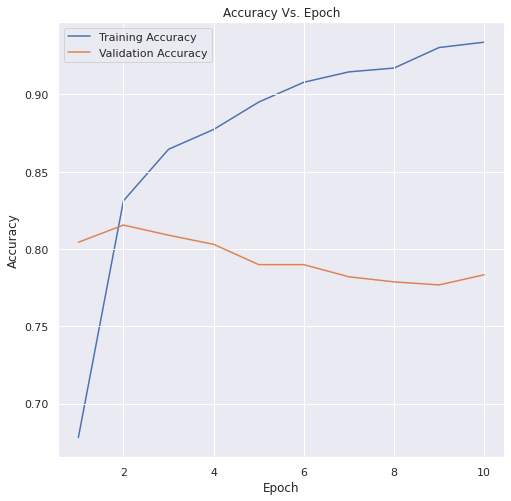

In [18]:
epochs = [i + 1 for i in range(10)]

line1, = plt.plot(epochs, history.history["accuracy"], zorder = 0, label = "Training Accuracy")
line2, = plt.plot(epochs, history.history["val_accuracy"], zorder = 1, label = "Validation Accuracy")

plt.legend(handles = [line1, line2])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs. Epoch")
plt.show()

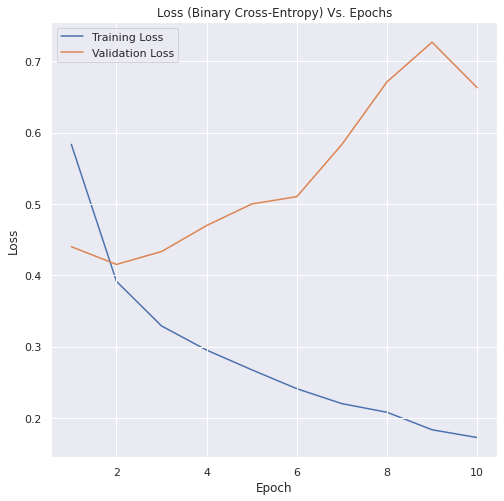

In [19]:
line1, = plt.plot(epochs, history.history["loss"], zorder = 0, label = "Training Loss")
line2, = plt.plot(epochs, history.history["val_loss"], zorder = 1, label = "Validation Loss")

plt.legend(handles = [line1, line2])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Binary Cross-Entropy) Vs. Epochs")
plt.show()

In [20]:
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(tweets_train['proper_text'].values)
X = tokenizer.texts_to_sequences(tweets_train['proper_text'].values)
X = pad_sequences(X, maxlen=50)

In [21]:
tokenizer.fit_on_texts(tweets_test['proper_text'].values)
test_token = tokenizer.texts_to_sequences(tweets_test['proper_text'].values)
test_token = pad_sequences(test_token, maxlen = 50)

Despite the output, I still decided to submit the model with the test data, but I changed a few of the hyperparameters, to see if it would change the results:

1) Increased epochs from 10 to 20

2) Changed batch size from 32 to 64

In [22]:
model = Sequential()
model.add(Embedding(max_features, 32,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.001)

model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

history = model.fit(X_train, y_train, epochs = 20, batch_size=64, validation_data=(X_test, y_test))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
96/96 [==============================] - 5s 26ms/step - loss: 0.6382 - accuracy: 0.6319 - val_loss: 0.5894 - val_accuracy: 0.7183
Epoch 2/20
96/96 [==============================] - 2s 20ms/step - loss: 0.4538 - accuracy: 0.8015 -

In [23]:
y_pre = model.predict(test_token)
y_pre = np.round(y_pre).astype(int).reshape(3263)
sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(), 'target':y_pre})
sub.to_csv('LSTM_submission.csv', index=False)

The original model received a score of 0.57891 on Kaggle, while the model with changed hyperparameters only received a 0.555, so the changed model didnt perform as well as I had hoped. As a result, I decided to construct a Bidirectional LSTM model. Using bidirectional will run your inputs in two ways, one from past to future and one from future to past and what differs this approach from unidirectional is that in the LSTM that runs backward you preserve information from the future and using the two hidden states combined you are able in any point in time to preserve information from both past and future. Therefore, I thought this model would understand the context better, and perform better overall. 

Citations: 

https://medium.com/@raghavaggarwal0089/bi-lstm-bc3d68da8bd0

https://keras.io/examples/nlp/bidirectional_lstm_imdb/



#### Bidirectional LSTM: 

In [24]:
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(tweets_train['proper_text'].values)
X = tokenizer.texts_to_sequences(tweets_train['proper_text'].values)
X = pad_sequences(X, maxlen=50)

tokenizer.fit_on_texts(tweets_test['proper_text'].values)
test_token = tokenizer.texts_to_sequences(tweets_test['proper_text'].values)
test_token = pad_sequences(test_token, maxlen = 50)

In [25]:
max_features = 5000  
maxlen = 50  

inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(max_features, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = keras.Model(inputs, outputs)

model_2.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model_2.summary()

history_2 = model_2.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 128)         640000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 837,761
Trainable params: 837,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [==============================] - 25s 86ms/step - loss: 0.5100 - accuracy: 0.7519 - val_loss: 0.4227 

In [26]:
y_pre_2 = model_2.predict(test_token)
y_pre_2 = np.round(y_pre_2).astype(int).reshape(3263)
sub_2 = pd.DataFrame({'id':sample_sub['id'].values.tolist(), 'target':y_pre_2})
sub_2.to_csv('BidirectionalLSTM_submission.csv', index=False)

Unfortunately, this model didnt perform as well as I would have liked either, as my accuracy score went down to a 0.56083 on Kaggle. If I wanted to see improvements on either of these models, I could have done things such as add more layers, or changed the learning rate. In addition, I could have explored other kinds of models to see if the accuracy would have improved.

### References:

1) https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a

2) https://medium.com/swlh/text-classification-using-tf-idf-7404e75565b8

3) https://dev.to/balapriya/tokenization-and-sequencing-in-tensorflow-3p0n

4) https://medium.com/@raghavaggarwal0089/bi-lstm-bc3d68da8bd0

5) https://medium.com/@dclengacher/keras-lstm-recurrent-neural-networks-c1f5febde03d

6) https://keras.io/examples/nlp/bidirectional_lstm_imdb/